# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.core.common import flatten
import seaborn as sns
%matplotlib inline

In [2]:
def split_to_strlist(text):
    '''Извлечение списка строк из строки'''
    if not(pd.isna(text)):
        return text[2:-2].split("\', \'")
    else:
        return ['']

    
def split_to_strlist2(text):
    '''Извлечение списка списков строк'''
    if pd.isna(text):
        return None
    elif text == '[[], []]':
        return ["['']", "['']"]
    else:
        lst = text[1:-1].split("\'], [\'")
        for index, text in enumerate(lst):
            if not(index - 1 < 0):
                lst[index] = '[\''+ lst[index]
            if not(index + 1 >= len(lst)):
                lst[index] = lst[index] + '\']'
        return lst

    
def str2dt(string_list):
    '''Извлечение даты из строки'''
    if len(string_list) >= 2:
        dt_list = []
        for string in string_list[1]:
            if string != '':
                dt_list.append(datetime.strptime(string, '%m/%d/%Y'))
        return [string_list[0], dt_list]        
    else:
        return [[], []]

    
def price_range2price_level(price_range):
    '''Преобразование строки Price Range в число 0, 1, 2 (NaN не преобразуется).'''
    if pd.isna(price_range):
        return price_range
    elif price_range == '$':
        return 0
    elif price_range == '$$$$':
        return 2
    else:
        return 1

    
def days_between(dt_first, dt_last):
    '''Количество дней между двумя датами.'''
    return (dt_last - dt_first).total_seconds()/86400


def aggfunc_apply(source_series, aggfunc, id_groups):
    '''Применение агреггационной функции к колонке.'''
    # aggfunc_apply() - вспомогательная функция для функции groupby2 (ниже)
    # Имеется расширенный набор функций, умеющих работать со значениями типа "список" в колонке.
    dest_series = []
    if aggfunc != 'drop':
        for id in id_groups:
            if aggfunc == 'index':
                current_row_lst = id
            else:
                current_row_lst = []
                for index in id_groups[id]:  
                    current_row_lst.append(source_series.loc[index])
                if aggfunc == 'list' or aggfunc == '': # Просто оставит список без изменений
                    pass
                elif aggfunc == 'merged_list': # сращивает списки "по вертикали"
                    current_row_lst2 = [[] for data in current_row_lst[0]]
                    for current_row in current_row_lst:
                        for n, data in enumerate(current_row):
                            current_row_lst2[n] += data
                    current_row_lst = current_row_lst2
                elif aggfunc == 'flatten': # список списков преобразуется в простой список
                    current_row_lst = list(flatten(current_row_lst))
                elif aggfunc == 'unique': # список списков преобразуется в простой список (только уникальные значения)
                    current_row_lst = list(set(flatten(current_row_lst)))
                elif aggfunc == 'sum': # сумма чисел в списке (NaN игнорируются!)
                    current_row_lst = pd.Series(current_row_lst).sum()
                elif aggfunc == 'mean': # среднее арифметическое чисел в списке (NaN игнорируются!)
                    current_row_lst = pd.Series(current_row_lst).mean()
                elif aggfunc == 'min': # наименьшее значение (NaN игнорируются!)
                    current_row_lst = pd.Series(current_row_lst).min()
                elif aggfunc == 'max': # наибольшее значение (NaN игнорируются!)
                    current_row_lst = pd.Series(current_row_lst).max()
                elif aggfunc == 'len_unique': # число уникальных значений в списке списков
                    current_row_lst = len(set(flatten(current_row_lst)))
                elif aggfunc == 'len_flatten': # число элементов в списке списков
                    current_row_lst = len(list(flatten(current_row_lst)))
                # можно добавлять другие полезные функции
            dest_series.append(current_row_lst)
    return dest_series      
    
    
def groupby2(source_dataframe, aggfunc_dict, count_col_name='Count', group_prefix='Group '):
    '''Более функциональный аналог функции pandas.groupby().
    Имеет расширенный набор агреггационных функций, применимых к колонкам со списками.'''
    # pandas.groupby() не умеет работать со списками в столбцах, поэтому создана данная функция
    # В разработке: применение нескольких агреггационных функций к одной колонке
    for col in source_dataframe.columns:
        if (aggfunc_dict[col] == 'index') or ((type(aggfunc_dict[col]) == list) and ('index' in aggfunc_dict[col])):
            id_groups = source_dataframe.groupby([col]).groups
            break
    first = True
    for col in source_dataframe.columns:
        if type(aggfunc_dict[col]) == str:
            aggfunc = aggfunc_dict[col]
            if aggfunc == 'index':
                groupcol = col
            else:
                groupcol = group_prefix + col + ' (' + aggfunc + ')'
            print(groupcol)
            source_series = source_dataframe[col]
            dest_series = aggfunc_apply(source_series, aggfunc, id_groups)
        elif type(aggfunc_dict[col]) == list:
            for aggfunc in aggfunc_dict[col]:
                if aggfunc == 'index':
                    groupcol = col
                else:
                    groupcol = group_prefix + col + ' (' + aggfunc + ')'
                print(groupcol)
                source_series = source_dataframe[col]
                dest_series = aggfunc_apply(source_series, aggfunc, id_groups)
        else:
            print('Недопустимое значения словаря агреггационных функций! Столбец',
                  col, ':', aggfunc_dict[col], 'проигнорирован.')
            break
        if dest_series != []:
            if first:
                dest_dataframe = pd.DataFrame(pd.Series(dest_series, name=groupcol))
                first = False
            else:
                dest_dataframe = dest_dataframe.join(pd.Series(dest_series, name=groupcol))
    dest_series = []
    for id in id_groups:
        dest_series.append(len(id_groups[id]))
    dest_dataframe = dest_dataframe.join(pd.Series(dest_series, name=count_col_name))
    return dest_dataframe


def explode2(source_dataframe, target_dataframe, index_col):
    '''Функция дедукции, обратная функции обобщения (индукции) groupby2().
    Позволяет создать групповые (обобщенные) колонки, которые можно присоединить к исходному датафрейму.'''
    # Медленно работает, возможно надо внутри тела функции список dest_list заменить на словарь
    first = True
    dest_list = []
    for target_index in target_dataframe.index:
        row = source_dataframe.loc[source_dataframe[index_col] == target_dataframe.loc[target_index][index_col]]
        dest_row = []
        for col in source_dataframe.columns:
            if col != index_col:                
                dest_row.append(row[col].values[0])
        dest_list.append(dest_row)
    dest_dataframe = pd.DataFrame(dest_list, columns=[col for col in source_dataframe.columns if col != index_col])
    return dest_dataframe


def find_index_col(source_dataframe, aggfunc_dict):
    '''Нахождение имени колонки-индекса.'''
    # Вспомогательная функция для build_relations() и collate()
    for col in source_dataframe.columns:
        aggfunc_list = aggfunc_dict[col]
        if type(aggfunc_list) == str:
            if aggfunc_list == 'index':
                index_col = col
                break
        elif type(aggfunc_list) == list:
            for aggfunc in aggfunc_list:
                if aggfunc == 'index':
                    index_col = col
                    break
        else:
            print('No index!')
    return index_col


def build_relations(source_dataframe, base_dataframe, aggfunc_dict, count_col_name='Count',
                    group_prefix='Group ', relation_prefix='Group Relative '):
    '''Функция построения числовых колонок относительных данных типа "Индивид / Группа".'''
    index_col = find_index_col(source_dataframe, aggfunc_dict)
    first = True
    for col in source_dataframe.select_dtypes(include=[np.number]):
        groupcol = group_prefix + col + ' (' + aggfunc_dict[col] + ')'
        relcol = relation_prefix + col + ' (' + aggfunc_dict[col] + ')'
        if groupcol in base_dataframe.columns and col != index_col:
            print(col, ':', groupcol, ':', relcol) 
            if first:
                dest_dataframe = pd.DataFrame(source_dataframe[col] / base_dataframe[groupcol], columns=[relcol])
                first = False
            else:
                dest_dataframe = dest_dataframe.join(pd.Series(source_dataframe[col] / base_dataframe[groupcol],
                                                               name=relcol))
    return dest_dataframe.join(base_dataframe[count_col_name])
    

def collate(source_dataframe, aggfunc_dict, count_col_name='Count',
            group_prefix='Group ', relation_prefix='Group Relative'):
    '''Очень умная функция сопоставления данных, которая последовательно запускает три функции:
     groupby2(), explode2(), build_relations().'''
    # Придумать более подходящее имя?!
    
    # 0. Поиск колонки-индекса
    index_col = find_index_col(source_dataframe, aggfunc_dict)
            
    # 1. Группировка данных по индексу
    print('\n\n=========1. groupby2()==========\n')
    group_dataframe = groupby2(source_dataframe,
                               aggfunc_dict,
                               count_col_name,
                               group_prefix)
    display(group_dataframe)
    
    # 2. Операция, обратная группировке данных
    print('\n\n=========2. explode2()==========\n')
    base_dataframe = explode2(group_dataframe[group_dataframe.columns],
                            source_dataframe,
                            index_col)
    display(base_dataframe)
    
    # 3. Построение колонок относительных данных
    print('\n\n=========3. build_relations()==========\n')
    dest_dataframe = build_relations(source_dataframe,
                                     base_dataframe,
                                     aggfunc_dict,
                                     count_col_name=count_col_name,
                                     group_prefix=group_prefix,
                                     relation_prefix=relation_prefix)
    display(dest_dataframe)
    
    return group_dataframe, base_dataframe, dest_dataframe


def fillnaby_groupvalues(source_series, base_series):
    '''Заполнение пропусков значениями полученными в результате группировки данных с помощью функций groupby2() и deduct().'''
    # Возможно следует встроить в функцию collate()
    dest_dict = {}
    for index, value in source_series.items():
        if np.isnan(value):
            dest_dict[index] = base_series.loc[index]
        else:
            dest_dict[index] = value
    return pd.Series(dest_dict)


def unique_values(series):
    '''Находит все уникальные значения в списках колонки'''
    # Используется в функции get_dummies2() (см. ниже)
    # В данном проекте не используется
    unique_lst = []
    for lst in series:
        for item in lst:
            if not(item in unique_lst): 
                unique_lst.append(item)
    return unique_lst


def get_dummies2(source_series):
    '''Более функциональный аналог функции pandas.get_dummies().
    Построение новых колонок по колонке, содержащей список строк.'''
    # В данном проекте не используется
    for index, item in enumerate(unique_values(source_series)):
        lst = []
        for item_list in source_series:
            if item in item_list:
                lst.append(1)
            else:
                lst.append(0)
        if index == 0:
            dest_dataframe = pd.DataFrame(lst, columns=[item])
        else:
            dest_dataframe = dest_dataframe.join(pd.Series(lst, name=item))
    return dest_dataframe

def groupby_values(source_dataframe, aggfunc_dict, value_groups_dict, count_col_name='Count'):
    '''Группировка данных по значениям'''
    # В данном проекте не используется
    for col in source_dataframe.columns:
        aggfunc_list = aggfunc_dict[col]
        if type(aggfunc_list) == str:
            if aggfunc_list == 'index':
                index_col = col
                break
        elif type(aggfunc_list) == list:
            for aggfunc in aggfunc_list:
                if aggfunc == 'index':
                    index_col = col
                    break
        else:
            print('No index!')
    for new_value, value_list in value_groups_dict.items():
        source_dataframe[index_col] = source_dataframe[index_col].apply(lambda x: new_value if (x in value_list) else x)
    dest_dataframe = groupby2(source_dataframe, aggfunc_dict, count_col_name=count_col_name)
    return dest_dataframe


def round05(x):
    '''Округление с точностью до 0,5'''
    return round(x*2)/2

In [3]:
df = pd.read_csv('main_task.xls')
display(df) # Исходный (необработанный) датасет

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963
...,...,...,...,...,...,...,...,...,...,...
39995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,4.5,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414
39996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,3.5,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036
39997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,4.5,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615
39998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,4.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838


In [4]:
# Сделаем копию датасета и будем работать с ним, оригинал сохранит информацию о пропусках и т.д.
df1 = df.copy()

In [5]:
# Преобразование колонки строковых данных в колонки списков строк
df1['Cuisine Style'] = df1['Cuisine Style'].apply(lambda item: split_to_strlist(item))
# Преобразование колонки строковых данных в список списков строк, второй элемент попутно преобразуется в datetime
df1['Reviews'] = df1['Reviews'].apply(lambda r: [split_to_strlist(text) for text in split_to_strlist2(r)]).apply(str2dt)
display(df1['Cuisine Style'])
display(df1['Reviews'])

0                        [European, French, International]
1                                                       []
2        [Japanese, Sushi, Asian, Grill, Vegetarian Fri...
3                                                       []
4          [German, Central European, Vegetarian Friendly]
                               ...                        
39995    [Italian, Vegetarian Friendly, Vegan Options, ...
39996    [French, American, Bar, European, Vegetarian F...
39997                                    [Japanese, Sushi]
39998    [Polish, European, Eastern European, Central E...
39999                                            [Spanish]
Name: Cuisine Style, Length: 40000, dtype: object

0        [[Good food at your doorstep, A good hotel res...
1        [[Unique cuisine, Delicious Nepalese food], [2...
2        [[Catch up with friends, Not exceptional], [20...
3                                                 [[], []]
4        [[Best place to try a Bavarian food, Nice buil...
                               ...                        
39995    [[The real Italian experience!, Wonderful food...
39996    [[Parisian atmosphere, Bit pricey but interest...
39997    [[Good by swedish standards, A hidden jewel in...
39998    [[Underground restaurant, Oldest Restaurant in...
39999    [[Average, Nice an informal], [2016-01-31 00:0...
Name: Reviews, Length: 40000, dtype: object

In [6]:
# Преобразование колонки строковых данных в колонку числовых данных (пропуски игнорируются)
df1['Price Level'] = df['Price Range'].apply(price_range2price_level)
display(df1['Price Level'].value_counts())

1.0    18412
0.0     6279
2.0     1423
Name: Price Level, dtype: int64

In [7]:
# Количество разновидностей кухонь
df1['Number of Styles'] = df1['Cuisine Style'].apply(lambda cs: len(cs) if cs != [''] else None)

In [8]:
# Период в днях между самым новым и старым отзывами ресторана. Если отзывов нет, то минус 1000 дней.
df1['Reviews Timedelta'] = df1['Reviews'].apply(lambda r: days_between(min(r[1]), max(r[1])) if r[1] != [] else -1000)
df1['Reviews Timedelta']

0          41.0
1         382.0
2           2.0
3       -1000.0
4         272.0
          ...  
39995      34.0
39996       9.0
39997    3127.0
39998      23.0
39999    1306.0
Name: Reviews Timedelta, Length: 40000, dtype: float64

In [9]:
# Давность самого старого отзыва ресторана (в днях).
# Вычисляется относительно даты 2018-02-26 - дата самого свежего отзыва по всем ресторанам.
# Если отзывов нет, то минус 1000 дней.
df1['First Review Time'] = df1['Reviews'].apply(lambda r: days_between(min(r[1]), datetime(2018, 2, 26)) if r[1] != [] else -1000)
df1['First Review Time']

0          98.0
1         617.0
2          51.0
3       -1000.0
4         372.0
          ...  
39995     106.0
39996      76.0
39997    3607.0
39998     253.0
39999    2063.0
Name: First Review Time, Length: 40000, dtype: float64

In [10]:
# Список колонок объектного типа (за исключением 'City', он еще понадобится)
object_cols = list(df1.select_dtypes(include=[np.object]).columns)
object_cols.remove('City')
print(object_cols)

['Restaurant_id', 'Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA']


,City,Ranking,Rating,Number of Reviews,Price Level,Number of Styles,Reviews Timedelta,First Review Time
0,Paris,5570.0,3.5,194.0,1.0,3.0,41.0,98.0
25,Warsaw,1077.0,5.0,2.0,0.0,4.0,-1000.0,-1000.0
28,Paris,10059.0,4.5,4.0,NaN,NaN,0.0,2382.0
31,Amsterdam,2011.0,4.5,15.0,1.0,2.0,241.0,419.0
38,Paris,11293.0,4.5,10.0,1.0,1.0,0.0,1086.0
...,...,...,...,...,...,...,...,...
39991,Paris,6656.0,5.0,5.0,1.0,4.0,-1000.0,-1000.0
39993,Paris,6058.0,4.0,16.0,NaN,NaN,342.0,399.0
39994,Paris,7075.0,4.5,6.0,1.0,4.0,-1000.0,-1000.0
39996,Paris,6341.0,3.5,542.0,1.0,5.0,9.0,76.0


C:\Users\Mikhail\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Mikhail\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


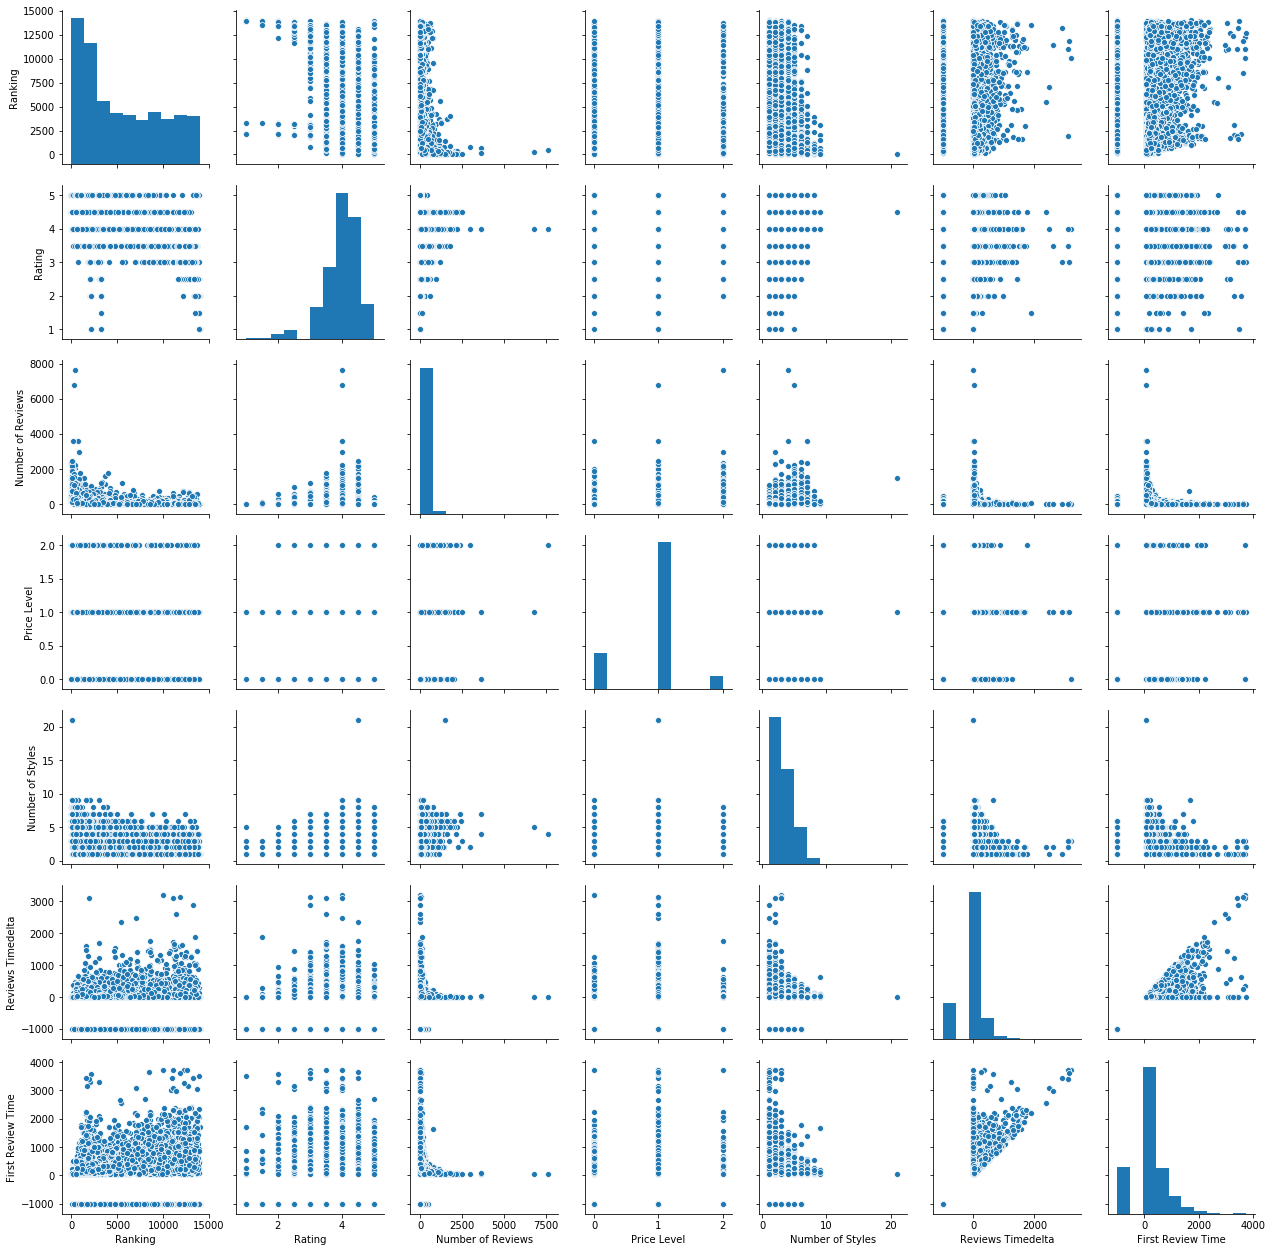

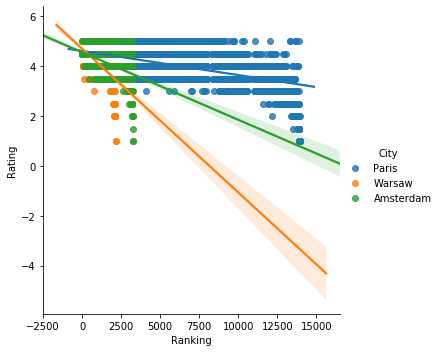

In [11]:
# Исследуем зависимость рейтинга от Ranking
# Вывод: зависимость достаточно сильная, но влияют также некоторые другие факторы
df3 = df1.drop(object_cols, axis=1)[(df1['City'].isin(['Paris', 'Amsterdam', 'Warsaw']))]
display(df3)
sns.pairplot(df3)
sns.lmplot(x='Ranking', y='Rating', data=df3, hue='City')

,City,Ranking,Rating,Number of Reviews,Price Level,Number of Styles,Reviews Timedelta,First Review Time
1978,Paris,12358.0,3.0,2.0,0.0,1.0,0.0,247.0
3135,Amsterdam,1801.0,5.0,3.0,0.0,1.0,0.0,82.0
3695,Warsaw,1831.0,3.5,3.0,0.0,1.0,-1000.0,-1000.0
5579,Paris,9304.0,4.5,5.0,0.0,1.0,0.0,597.0
6011,Paris,9058.0,4.5,5.0,0.0,1.0,0.0,114.0
6914,Paris,13410.0,2.5,5.0,0.0,1.0,-1000.0,-1000.0
7067,Paris,13887.0,1.5,3.0,0.0,1.0,0.0,457.0
7877,Warsaw,1834.0,3.5,3.0,0.0,1.0,0.0,186.0
8008,Paris,7345.0,5.0,3.0,0.0,1.0,0.0,260.0
9793,Amsterdam,2473.0,4.5,2.0,0.0,1.0,-1000.0,-1000.0


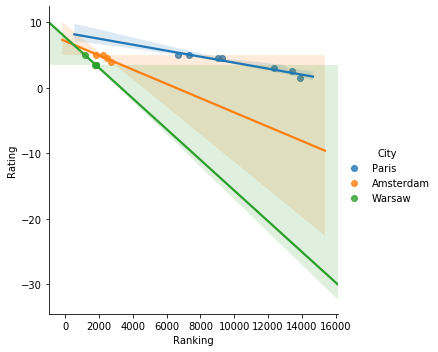

In [12]:
# Дополним предыдущее исследование фиксацией трех факторов. Отберем только те рестораны, у которых:
# Число отзывов от 0 до 5
# Уровень цен самый низкий
# Один вид кухни
# По диаграмме отмечаем, что эти три фактора являются решающими наравне с фактором "Город"
s1 = df1['Number of Reviews'].between(0, 5)
s2 = df1['Price Level'] == 0
s3 = df1['Number of Styles'].isin([1])
df4 = df1.drop(object_cols, axis=1)[(df1['City'].isin(['Paris', 'Amsterdam', 'Warsaw'])) & s1 & s2 & s3]
display(df4)
sns.lmplot(x='Ranking', y='Rating', data=df4, hue='City')

In [13]:
# Здесь очень важная часть пайплайна - функция collate():
# 0. df1 - исходный датафрейм
# 1. группируем данные по городам и высчитываем средние значения для каждого города (df10),
# 2. средние значения по городам приводим в соответствие к каждому ресторану (df11)
# 3. средние значения по городам используем для вычисления относительных характеристик ресторана (df12 = df1 / df11)
aggfunc_df = {'Restaurant_id': 'drop',
              'City':          'index',
              'Cuisine Style': 'drop',
              'Ranking':       'mean',
              'Rating':        'drop',
              'Price Range':   'drop',
              'Number of Reviews': 'mean',
              'Reviews':       'drop',
              'URL_TA':        'drop',
              'ID_TA':         'drop',
              'Price Level':   'mean',
              'Number of Styles': 'mean',
              'Reviews Timedelta': 'drop',
              'First Review Time': 'drop'}
df10, df11, df12 = collate(df1, aggfunc_df, count_col_name='Count', group_prefix='City ', relation_prefix='City Relative ')



=========1. groupby2()==========

City Restaurant_id (drop)
City
City Cuisine Style (drop)
City Ranking (mean)
City Rating (drop)
City Price Range (drop)
City Number of Reviews (mean)
City Reviews (drop)
City URL_TA (drop)
City ID_TA (drop)
City Price Level (mean)
City Number of Styles (mean)
City Reviews Timedelta (drop)
City First Review Time (drop)


,City,City Ranking (mean),City Number of Reviews (mean),City Price Level (mean),City Number of Styles (mean),Count
0,Amsterdam,1580.943831,146.630309,0.842482,3.690247,1086
1,Athens,881.108280,98.538200,0.723256,2.964637,628
2,Barcelona,3914.144111,132.534747,0.782536,3.166107,2734
3,Berlin,3266.237123,66.522809,0.754799,2.941958,2155
4,Bratislava,453.112957,53.089147,0.835714,2.973822,301
5,Brussels,1535.347170,89.090081,0.857351,2.996226,1060
6,Budapest,1220.811275,159.106809,0.710197,3.814701,816
7,Copenhagen,974.699545,90.686998,0.902778,3.316973,659
8,Dublin,983.725111,155.654147,0.772727,3.738434,673
9,Edinburgh,873.041946,232.112263,0.711968,4.155303,596




=========2. explode2()==========



,City Ranking (mean),City Number of Reviews (mean),City Price Level (mean),City Number of Styles (mean),Count
0,6933.012048,120.146373,0.897227,2.470588,4897
1,1242.386585,77.935356,0.943182,3.184071,820
2,8198.461873,137.969490,0.804437,3.364607,5757
3,3266.237123,66.522809,0.754799,2.941958,2155
4,1370.539754,81.281401,0.911348,3.047170,893
...,...,...,...,...,...
39995,3098.143929,173.712808,0.738690,3.044473,2133
39996,6933.012048,120.146373,0.897227,2.470588,4897
39997,1242.386585,77.935356,0.943182,3.184071,820
39998,1063.039890,64.676380,0.810502,3.154876,727




=========3. build_relations()==========

Ranking : City Ranking (mean) : City Relative Ranking (mean)
Number of Reviews : City Number of Reviews (mean) : City Relative Number of Reviews (mean)
Price Level : City Price Level (mean) : City Relative Price Level (mean)
Number of Styles : City Number of Styles (mean) : City Relative Number of Styles (mean)


,City Relative Ranking (mean),City Relative Number of Reviews (mean),City Relative Price Level (mean),City Relative Number of Styles (mean),Count
0,0.803403,1.614697,1.114545,1.214286,4897
1,1.237135,0.128311,NaN,NaN,820
2,0.043057,4.986610,2.486211,2.080481,5757
3,1.058711,0.045097,NaN,NaN,2155
4,0.453106,1.033447,1.097276,0.984520,893
...,...,...,...,...,...
39995,0.161387,0.454774,1.353749,1.313856,2133
39996,0.914610,4.511164,1.114545,2.023810,4897
39997,1.329699,0.051325,NaN,0.628127,820
39998,0.602988,1.082312,1.233803,1.584848,727


In [14]:
# Функцию collate() можно применить также к колонке 'Restaurant_id',
# т.е. сгруппировать данные по принадледности к сети ресторанов.
# Однако городские показатели являются более значимыми и полноценными.

In [15]:
# Заполнение пропусков значениями, соответствующими средним величинам по городу
# Можно пропускив этих колонках не заполнять, так как в дальнейшим эти столбцы не используются,
# так как будут заменены на колонки относительных данных (см. ниже)
df1['Number of Reviews'] = fillnaby_groupvalues(df1['Number of Reviews'], df11['City Number of Reviews (mean)'])
df1['Price Level'] = fillnaby_groupvalues(df1['Price Level'], df11['City Price Level (mean)'])
df1['Number of Styles'] = fillnaby_groupvalues(df1['Number of Styles'], df11['City Number of Styles (mean)'])

In [16]:
# Заполнение пропусков в колонках относительных данных
df12['City Relative Number of Reviews (mean)'].fillna(1.0, inplace=True)
df12['City Relative Price Level (mean)'].fillna(1.0, inplace=True)
df12['City Relative Number of Styles (mean)'].fillna(1.0, inplace=True)

In [17]:
# Сформируем новые колонки количества присутствия некоторых ключевых слов в отзывах ресторанов
for keyword in ['Average', 'Bad', 'Cheap', 'Expensive', 'Rude', 'Cool', 'Atmosphere', 'Tasty', 'Quick', 'Terrible', 'Good', 'Nice']:
    df1['Reviews ' + keyword] = df1['Reviews'].apply(lambda r: [keyword.lower() in text.lower() for text in r[0]].count(True))
    display(df1['Reviews ' + keyword].value_counts())
display(df1)

0    39275
1      711
2       14
Name: Reviews Average, dtype: int64

0    39449
1      540
2       11
Name: Reviews Bad, dtype: int64

0    39370
1      606
2       24
Name: Reviews Cheap, dtype: int64

0    39553
1      440
2        7
Name: Reviews Expensive, dtype: int64

0    39831
1      166
2        3
Name: Reviews Rude, dtype: int64

0    39771
1      228
2        1
Name: Reviews Cool, dtype: int64

0    38973
1     1008
2       19
Name: Reviews Atmosphere, dtype: int64

0    38699
1     1269
2       32
Name: Reviews Tasty, dtype: int64

0    39268
1      717
2       15
Name: Reviews Quick, dtype: int64

0    39757
1      241
2        2
Name: Reviews Terrible, dtype: int64

0    31909
1     7299
2      792
Name: Reviews Good, dtype: int64

0    35739
1     4052
2      209
Name: Reviews Nice, dtype: int64

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Reviews Cheap,Reviews Expensive,Reviews Rude,Reviews Cool,Reviews Atmosphere,Reviews Tasty,Reviews Quick,Reviews Terrible,Reviews Good,Reviews Nice
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,$$ - $$$,194.0,"[[Good food at your doorstep, A good hotel res...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,...,0,0,0,0,0,0,0,0,2,0
1,id_1535,Stockholm,[],1537.0,4.0,NaN,10.0,"[[Unique cuisine, Delicious Nepalese food], [2...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,...,0,0,0,0,0,0,0,0,0,0
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,$$$$,688.0,"[[Catch up with friends, Not exceptional], [20...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,...,0,0,0,0,0,0,0,0,0,0
3,id_3456,Berlin,[],3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,...,0,0,0,0,0,0,0,0,0,0
4,id_615,Munich,"[German, Central European, Vegetarian Friendly]",621.0,4.0,$$ - $$$,84.0,"[[Best place to try a Bavarian food, Nice buil...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,id_499,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,4.5,$$ - $$$,79.0,"[[The real Italian experience!, Wonderful food...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,...,0,0,0,0,0,0,0,0,0,0
39996,id_6340,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,3.5,$$ - $$$,542.0,"[[Parisian atmosphere, Bit pricey but interest...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,...,0,0,0,0,1,0,0,0,1,0
39997,id_1649,Stockholm,"[Japanese, Sushi]",1652.0,4.5,NaN,4.0,"[[Good by swedish standards, A hidden jewel in...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,...,0,0,0,0,0,0,0,0,1,0
39998,id_640,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,4.0,$$ - $$$,70.0,"[[Underground restaurant, Oldest Restaurant in...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,...,0,0,0,0,0,0,0,0,0,0


# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [18]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df1.drop(['Rating', 'Ranking', 'Price Level', 'Number of Styles', 'Number of Reviews']
              + object_cols + ['City'], axis=1).join(df11.drop(['Count'], axis=1)).join(df12.drop(['Count'], axis=1))
X.info()
y = df['Rating']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 22 columns):
Reviews Timedelta                         40000 non-null float64
First Review Time                         40000 non-null float64
Reviews Average                           40000 non-null int64
Reviews Bad                               40000 non-null int64
Reviews Cheap                             40000 non-null int64
Reviews Expensive                         40000 non-null int64
Reviews Rude                              40000 non-null int64
Reviews Cool                              40000 non-null int64
Reviews Atmosphere                        40000 non-null int64
Reviews Tasty                             40000 non-null int64
Reviews Quick                             40000 non-null int64
Reviews Terrible                          40000 non-null int64
Reviews Good                              40000 non-null int64
Reviews Nice                              40000 non-null int64
City 

In [19]:
display(X)

,Reviews Timedelta,First Review Time,Reviews Average,Reviews Bad,Reviews Cheap,Reviews Expensive,Reviews Rude,Reviews Cool,Reviews Atmosphere,Reviews Tasty,...,Reviews Good,Reviews Nice,City Ranking (mean),City Number of Reviews (mean),City Price Level (mean),City Number of Styles (mean),City Relative Ranking (mean),City Relative Number of Reviews (mean),City Relative Price Level (mean),City Relative Number of Styles (mean)
0,41.0,98.0,0,0,0,0,0,0,0,0,...,2,0,6933.012048,120.146373,0.897227,2.470588,0.803403,1.614697,1.114545,1.214286
1,382.0,617.0,0,0,0,0,0,0,0,0,...,0,0,1242.386585,77.935356,0.943182,3.184071,1.237135,0.128311,1.000000,1.000000
2,2.0,51.0,0,0,0,0,0,0,0,0,...,0,0,8198.461873,137.969490,0.804437,3.364607,0.043057,4.986610,2.486211,2.080481
3,-1000.0,-1000.0,0,0,0,0,0,0,0,0,...,0,0,3266.237123,66.522809,0.754799,2.941958,1.058711,0.045097,1.000000,1.000000
4,272.0,372.0,0,0,0,0,0,0,0,0,...,0,1,1370.539754,81.281401,0.911348,3.047170,0.453106,1.033447,1.097276,0.984520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,34.0,106.0,0,0,0,0,0,0,0,0,...,0,0,3098.143929,173.712808,0.738690,3.044473,0.161387,0.454774,1.353749,1.313856
39996,9.0,76.0,0,0,0,0,0,0,1,0,...,1,0,6933.012048,120.146373,0.897227,2.470588,0.914610,4.511164,1.114545,2.023810
39997,3127.0,3607.0,0,0,0,0,0,0,0,0,...,1,0,1242.386585,77.935356,0.943182,3.184071,1.329699,0.051325,1.000000,0.628127
39998,23.0,253.0,0,0,0,0,0,0,0,0,...,0,0,1063.039890,64.676380,0.810502,3.154876,0.602988,1.082312,1.233803,1.584848


In [20]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [21]:
RANDOM_SEED = 42
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

# Создаём, обучаем и тестируем модель

In [22]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [23]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [24]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, list(map(round05, y_pred))))

# К значениям y_pred применена функция округления до 0.5 так, как это делает сервис TripAdvisor.

MAE: 0.1732
